In [58]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = "DW_2000Q_2_1"
api_key = 'DEV-3142f58be13a0aacd44657b15b8fb9832ba3bdac'

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [72]:
# Import Asset Class data

dataset = 'asset_class' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('%s/%s_corr.npy' % (dataset, dataset))
dates = np.load('%s/%s_dates.npy' % (dataset, dataset))
nodes = np.load('%s/%s_nodes.npy' % (dataset, dataset))
nodes_descr = np.load('%s/%s_nodes_descr.npy' % (dataset, dataset))

num_examples = corr_tensor.shape[0]
dim = corr_tensor.shape[1]

In [73]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if not corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

In [74]:
# Test to see if DW comp. is working
corr_mat = corr_tensor[int(num_examples/2), :, :]
        
corr_mat[(corr_mat > -1*0.5) & (corr_mat < 0.5)] = 0
G, density = make_graph(corr_mat, nodes, 'signed')

imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
frustration_score = len(list(imbalance.keys()))/G.number_of_edges()

In [75]:
# Plot graph density for each threshold. 
thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :]
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'signed')
        
        density_array.append(density)
    
    density_distr.append(density_array)

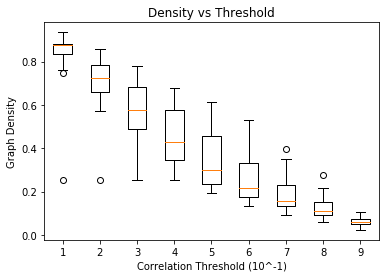

In [76]:
plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("Density vs Threshold")
plt.show()

In [77]:
# Create graph for each month and calculate frustration. 

frustration_array = []
date_array = []
density_array = []
threshold_array = []

count = 0
for i in np.arange(0.3, 0.8, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :]
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'signed')

        try:
            imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
            frustration_score = len(list(imbalance.keys()))/G.number_of_edges()
            count += 1
            
            if count % 10 == 0:
                print("iteration: i = %f, j = %d" % (i,j))
            
            threshold_array.append(i)
            frustration_array.append(frustration_score)
            density_array.append(density)
            date_array.append(dates[j*5])
        except:
            pass

iteration: i = 0.300000, j = 10
iteration: i = 0.300000, j = 20
iteration: i = 0.400000, j = 7
iteration: i = 0.400000, j = 17
iteration: i = 0.500000, j = 4
iteration: i = 0.500000, j = 14
iteration: i = 0.600000, j = 1
iteration: i = 0.600000, j = 11
iteration: i = 0.600000, j = 21
iteration: i = 0.700000, j = 8
iteration: i = 0.700000, j = 18


In [78]:
assert len(frustration_array) == len(date_array) == len(density_array) == len(threshold_array)

In [79]:
len(frustration_array)

115

In [83]:
# Create Pandas DataFrame for results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                             "frustration_score": frustration_array}).to_csv("%s_res.csv" % (dataset))